# Autoencoder Denoising

In [30]:
%pip install torchsummary
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
import random as r
from scipy.signal import savgol_filter, wiener

Looking in indexes: https://nexus.intern/repository/pypi-group-dap/simple
Note: you may need to restart the kernel to use updated packages.


In [8]:
class Graph:
    def __init__(self, x1, y1, x2, y2):
        self.p1 = torch.tensor((x1,y1))
        self.p2 = torch.tensor((x2,y2))

    def bresenham(self, x1, y1, x2, y2):
        points = []
        dx = abs(x2 - x1)
        dy = -abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx + dy
        while True:
            points.append((x1.item(), y1.item()))
            if x1 == x2 and y1 == y2:
                break
            e2 = 2 * err
            if e2 > dy:
                err += dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy
        return points

    def draw_on_tensor(self, tensor, strength=1):
        points = self.bresenham(*self.p1, *self.p2)
        for x, y in points:
            tensor[x, y] = strength

In [9]:
def get_train_data(n_ex, size, noise, max_lines, strength=1):
    dx, dy = size
    data = torch.zeros((n_ex, dx, dy))
    for i in range(n_ex):
        for j in range(r.randint(0, max_lines)):
            random_x = [r.randint(0, dx-1) for _ in range(2)]
            random_y = [r.randint(0, dy-1) for _ in range(2)]
            # random_x.sort(), random_y.sort()
            rnd_graph = Graph(random_x[0], random_y[0], random_x[1], random_y[1])
            rnd_graph.draw_on_tensor(data[i,:,:], strength=strength)

    noise = torch.randn((n_ex, dx, dy)) * noise

    train = data + noise
    label = data

    return train, label


In [124]:
wid, hei = 32, 32
n_ex = 5000
noise = 0.2
max_lines = 5

train, label = get_train_data(n_ex, (wid,hei), noise, max_lines)
eval_input, eval_label = get_train_data(100, (wid, hei), noise, max_lines)

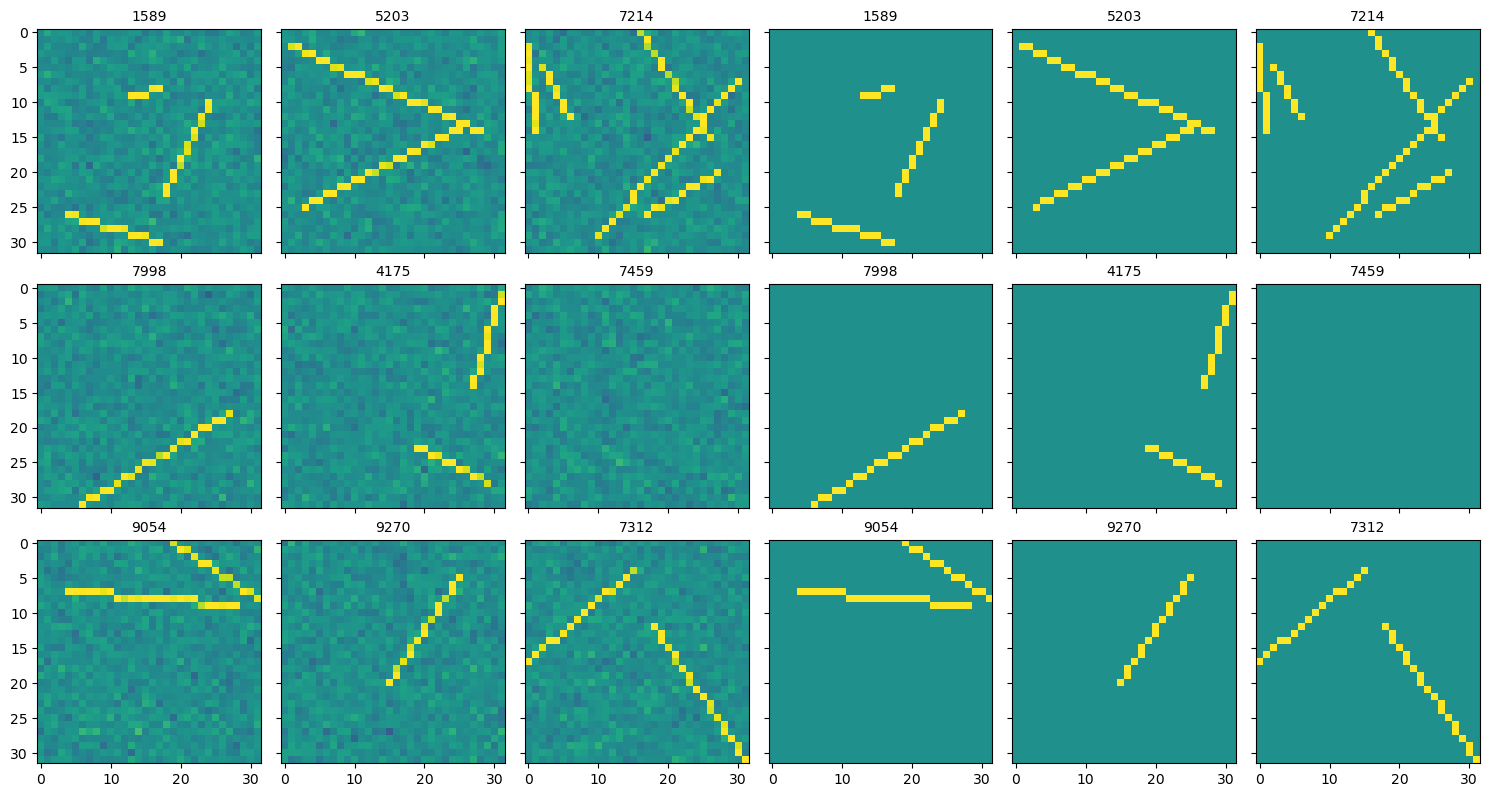

In [11]:
n_images = 9
rows = int(n_images**0.5)
fig, ax = plt.subplots(rows, 2*rows, figsize=(15, 8), sharex=True, sharey=True, tight_layout=True)
ax = ax.reshape((-1, 2), order='F')
for i in range(n_images):
    ix = r.randint(0, n_ex-1)
    ax[i, 0].imshow(train[ix], vmin=-1, vmax=1)
    ax[i, 1].imshow(label[ix], vmin=-1, vmax=1)
    ax[i, 0].set_title(ix, fontsize=10)
    ax[i, 1].set_title(ix, fontsize=10)

In [114]:
class Denoiser(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.ModuleList([
                                            torch.nn.Conv2d(1, 10, (5, 5), padding=2),
                                            torch.nn.Conv2d(10, 20, (3, 3), padding=1, groups=2),
                                            # torch.nn.Conv2d(20, 30, (3, 3), padding=1),
                                            # torch.nn.Conv2d(20, 50, (3, 3), padding=1)
                                            ])
        self.decoder = torch.nn.ModuleList([
                                            # torch.nn.ConvTranspose2d(50, 20, (3, 3), stride=2, padding=1, output_padding=1),
                                            # torch.nn.ConvTranspose2d(30, 20, (3, 3), stride=2, padding=1, output_padding=1),
                                            torch.nn.ConvTranspose2d(20, 10, (3, 3), stride=2, padding=1, output_padding=1, groups=2),
                                            torch.nn.ConvTranspose2d(10, 1, (5, 5), stride=2, padding=2, output_padding=1)
                                            ])
        self.max_pool = torch.nn.MaxPool2d((2, 2))
        self.non_linearity = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout2d(p=0.05)

    def forward(self, x):
        if len(x.shape) < 4:
            x = x.view(-1, 1, wid, hei)

        x = self.apply_encoder(x)

        x = self.apply_decoder(x)

        return x[:, 0, :, :]

    def apply_encoder(self, x):
        for lay in self.encoder:
            x = lay(x)
            # x = self.dropout(x)
            x = self.non_linearity(x)
            # x = x + resi
            x = self.max_pool(x)

        return x

    def apply_decoder(self, x):
        for lay in self.decoder:
            x = lay(x)
            x = self.non_linearity(x)

        return x

In [115]:
train.view((-1,1,wid,hei)).shape

torch.Size([10000, 1, 32, 32])

In [116]:
network = Denoiser()
optim = torch.optim.Adamax(network.parameters(), lr=0.01)
lossi_all = {'train': [], 'val': []}
summary(network, (1, wid, hei))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             260
              Tanh-2           [-1, 10, 32, 32]               0
         MaxPool2d-3           [-1, 10, 16, 16]               0
            Conv2d-4           [-1, 20, 16, 16]             920
              Tanh-5           [-1, 20, 16, 16]               0
         MaxPool2d-6             [-1, 20, 8, 8]               0
   ConvTranspose2d-7           [-1, 10, 16, 16]             910
              Tanh-8           [-1, 10, 16, 16]               0
   ConvTranspose2d-9            [-1, 1, 32, 32]             251
             Tanh-10            [-1, 1, 32, 32]               0
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.01
Estimated Total

In [117]:
latent_pres = network.apply_encoder(train[42].view((-1,1,wid,hei)))
latent_pres.shape

torch.Size([1, 20, 8, 8])

IndexError: index 20 is out of bounds for dimension 1 with size 20

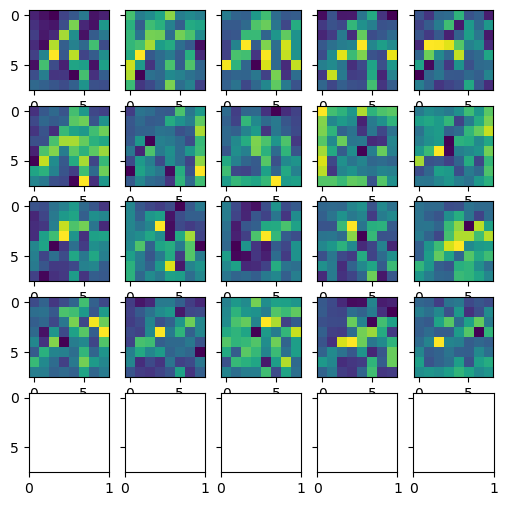

In [118]:
with torch.no_grad():
    n = 25
    fig, ax = plt.subplots(int(n**0.5), int(n**0.5), figsize=(6, 6), sharey=True)
    ax = ax.flatten()
    for i in range(n):
        ax[i].imshow(latent_pres[0,i])

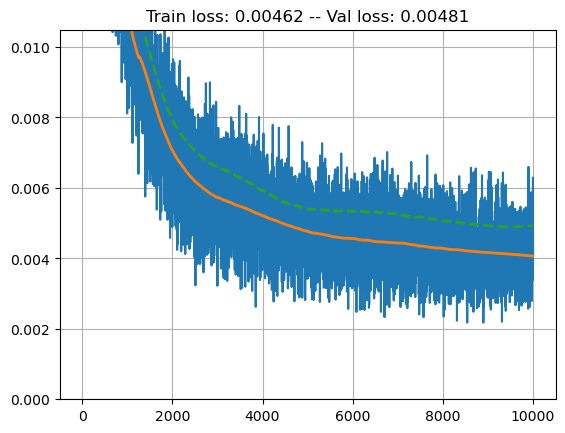

In [120]:
steps = 5000
batch_size = 50
lossi = []
lossi_val = []


for _ in range(steps):
    n_ex, wid, hei = train.shape
    ix = torch.randint(0, n_ex-1, (batch_size,))

    xtr = train[ix]
    ytr = label[ix]

    network.train()
    optim.zero_grad()
    pred = network(xtr)
    loss = torch.nn.functional.mse_loss(pred, ytr)

    loss.backward()
    optim.step()

    network.eval()
    with torch.no_grad():
        ix = torch.randint(0, len(eval_input), (20,))
        xval, yval = eval_input[ix], eval_label[ix]
        val_pred = network(xval)
        val_loss = torch.nn.functional.mse_loss(val_pred, yval)
        lossi_val.append(val_loss.item())

    lossi.append(loss.item())
lossi_all['train'] += lossi
lossi_all['val'] += lossi_val

plt.plot(lossi_all['train'])
plt.plot(savgol_filter(lossi_all['train'], steps // 2, 3), linewidth=2)
plt.plot(savgol_filter(lossi_all['val'], steps // 2, 3), linestyle='--', linewidth=2)
plt.ylim([0, np.mean(lossi_all['train'])+np.std(lossi_all['train'])])
plt.title(f"Train loss: {np.mean(lossi_all['train'][-10:]):.5f} -- Val loss: {np.mean(lossi_all['val'][-10:]):.5f}")
plt.grid()
plt.show()

one layer - without drop: 0.00342 / 0.00312 (6k) \
one layer - with drop: 0.01274 / 0.01041 (3k) \
one layer - without drop - residual enc.: 0.00786 / 0.00749 (5k) \
two layer - no drop - no resi.: 0.00484 / 0.00531 (11k)

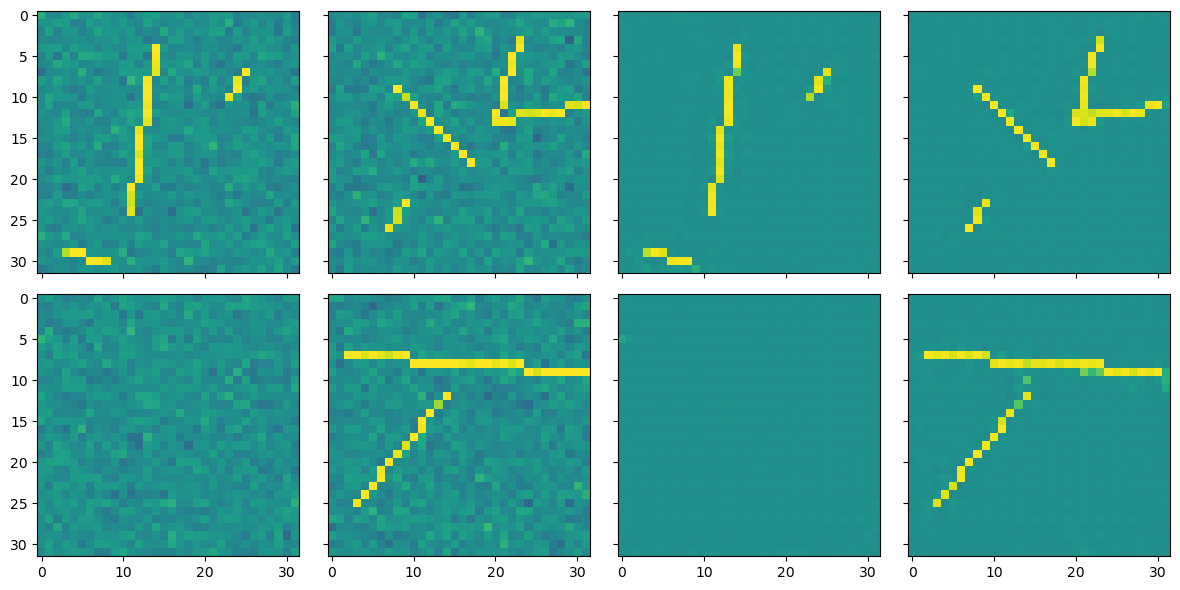

In [121]:
network.eval()

n_images = 4
rows = int(n_images**0.5)
fig, ax = plt.subplots(rows, 2*rows, figsize=(12, 6), sharex=True, sharey=True, tight_layout=True)
ax = ax.reshape((-1, 2), order='F')
for i in range(n_images):
    ax[i, 0].imshow(train[i], vmin=-1, vmax=1)
    with torch.no_grad():
        ax[i, 1].imshow(network(train[i])[0], vmin=-1, vmax=1)

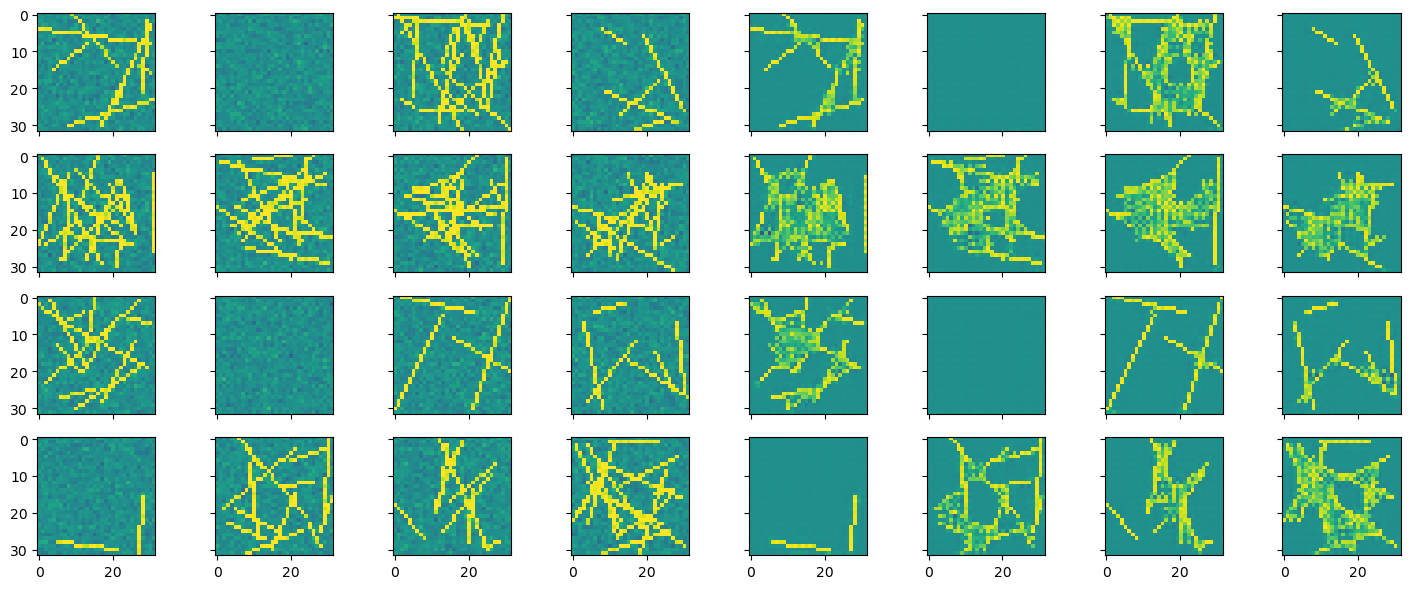

In [122]:
val_tr, val_lb = get_train_data(16, (wid,hei), noise, max_lines=20)

network.eval()

n_images = 16
rows = int(n_images**0.5)
fig, ax = plt.subplots(rows, 2*rows, figsize=(15, 6), sharex=True, sharey=True, tight_layout=True)
ax = ax.reshape((-1, 2), order='F')
for i in range(n_images):
    ax[i, 0].imshow(val_tr[i], vmin=-1, vmax=1)
    with torch.no_grad():
        ax[i, 1].imshow(network(val_tr[i])[0], vmin=-1, vmax=1)

In [46]:
for i in network.parameters():
    print(i.shape)

torch.Size([10, 1, 5, 5])
torch.Size([10])
torch.Size([20, 10, 3, 3])
torch.Size([20])
torch.Size([20, 10, 3, 3])
torch.Size([10])
torch.Size([10, 1, 5, 5])
torch.Size([1])


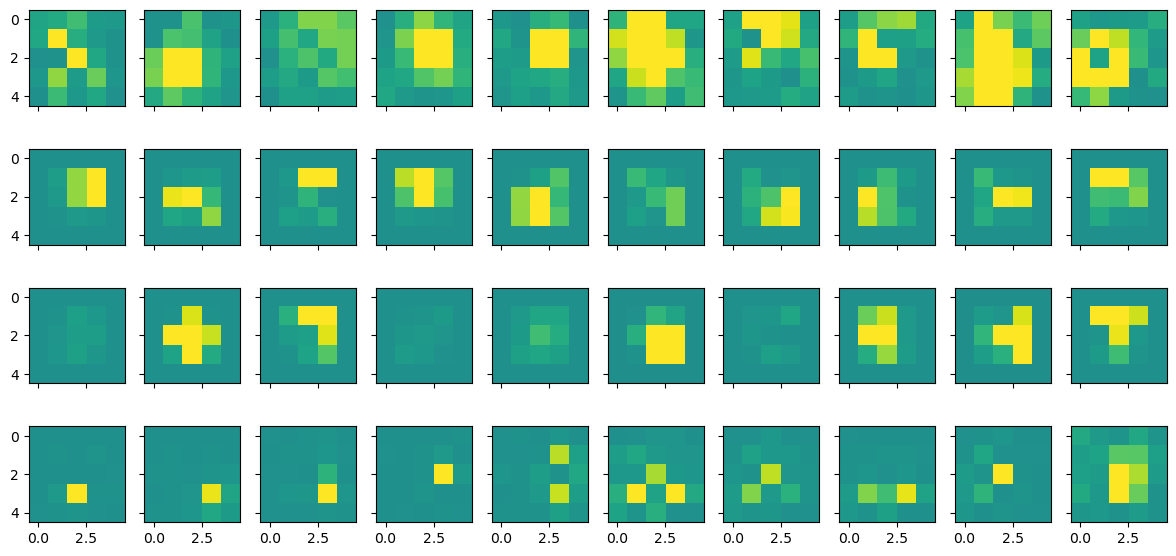

In [123]:
with torch.no_grad():
    filter_num = 0
    params = [i for i in network.parameters() if len(i.shape) > 1]
    fig, ax = plt.subplots(len(params), 10, figsize=(12, 6), sharey=True, sharex=True, tight_layout=True)
    for i in range(10):
        for j, t in enumerate(params):
            ax[j, i].imshow(np.abs(t[i, filter_num]) if t.shape[-1] == 5 else torch.nn.functional.pad(np.abs(t[i, filter_num]), (1, 1, 1, 1)), vmin=-.5, vmax=.5)
    plt.show()

# Next